In [1]:
import pandas as pd

train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')

print('train:', train.shape)
print('test:', test.shape)

train: (42000, 785)
test: (28000, 784)


In [2]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TrainDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.labels = dataframe.iloc[:, 0].values
        self.images = dataframe.iloc[:, 1:].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.images[index].reshape(28, 28).astype(np.uint8)
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        
        return image, label

class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.images = dataframe.values
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index].reshape(28, 28).astype(np.uint8)
        if self.transform:
            image = self.transform(image)
        
        return image

train_mean = train.drop('label', axis=1).values.mean()/255
train_std = train.drop('label', axis=1).values.std()/255

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

train_data = TrainDataset(train, transform=train_transform)
test_data = TestDataset(test, transform=test_transform)

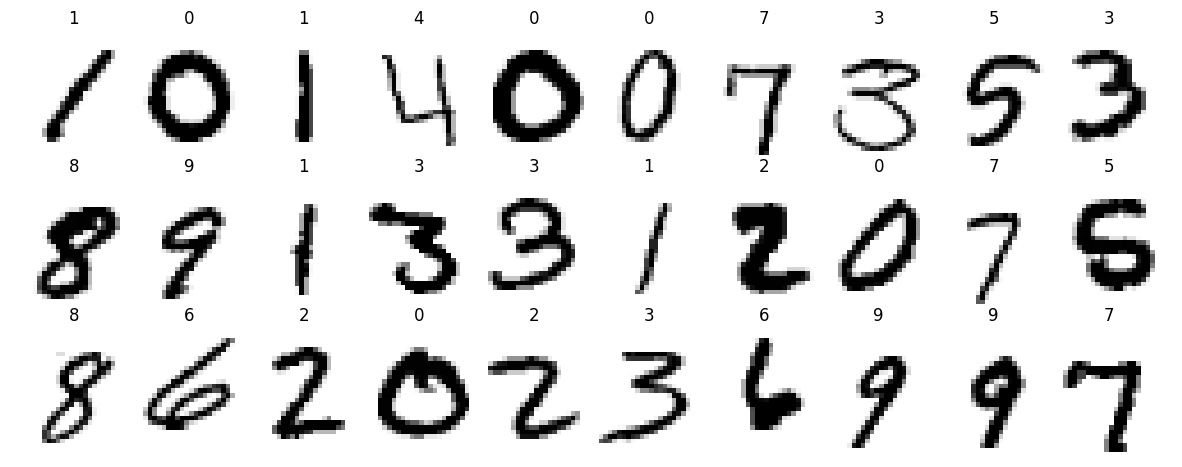

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(train_data.images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.title(train_data.labels[i])
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [6]:
from torch import nn, optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10),
        )   
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [7]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

In [8]:
import numpy as np
import torch
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('mps')

batch_size = 100
learning_rate = 0.001
epochs = 250
running_losses_list, val_losses_list, val_accuracies_list = [], [], []

for fold, (train_ids, val_ids) in enumerate(kf.split(train_data)):
    train_sampler = SubsetRandomSampler(train_ids)
    val_sampler = SubsetRandomSampler(val_ids)
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    running_loss_min = np.inf
    val_loss_min = np.inf

    running_losses, val_losses, val_accuracies = [], [], []
    
    for e in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        val_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        
        running_losses.append(running_loss/total)
        val_losses.append(val_loss/total)
        val_accuracies.append(val_accuracy)

        network_learned = (running_loss < running_loss_min) & (val_loss < val_loss_min)
        if network_learned:
            running_loss_min = running_loss
            val_loss_min = val_loss
            torch.save(model.state_dict(), 'model_mnist_' + str(fold+1) + '.pt')
            print(f'fold {fold+1} | epoch {e+1} | {running_loss/total:.3f} | {val_loss/total:.3f} | {val_accuracy:.3f} | network improved')
        else:
            print(f'fold {fold+1} | epoch {e+1} | {running_loss/total:.3f} | {val_loss/total:.3f} | {val_accuracy:.3f}')

    running_losses_list.append(running_losses)
    val_losses_list.append(val_losses)
    val_accuracies_list.append(val_accuracies)

fold 1 | epoch 1 | 0.087 | 0.016 | 0.546 | network improved
fold 1 | epoch 2 | 0.061 | 0.010 | 0.740 | network improved
fold 1 | epoch 3 | 0.045 | 0.007 | 0.812 | network improved
fold 1 | epoch 4 | 0.035 | 0.005 | 0.859 | network improved
fold 1 | epoch 5 | 0.028 | 0.004 | 0.891 | network improved
fold 1 | epoch 6 | 0.024 | 0.004 | 0.907 | network improved
fold 1 | epoch 7 | 0.021 | 0.003 | 0.921 | network improved
fold 1 | epoch 8 | 0.019 | 0.003 | 0.929 | network improved
fold 1 | epoch 9 | 0.017 | 0.002 | 0.933 | network improved
fold 1 | epoch 10 | 0.016 | 0.002 | 0.939 | network improved
fold 1 | epoch 11 | 0.015 | 0.002 | 0.948 | network improved
fold 1 | epoch 12 | 0.014 | 0.002 | 0.948 | network improved
fold 1 | epoch 13 | 0.013 | 0.002 | 0.951 | network improved
fold 1 | epoch 14 | 0.012 | 0.002 | 0.953 | network improved
fold 1 | epoch 15 | 0.012 | 0.002 | 0.959 | network improved
fold 1 | epoch 16 | 0.011 | 0.001 | 0.960 | network improved
fold 1 | epoch 17 | 0.011 | 0.001

In [10]:
models = []
for i in range(0, 5):
    model = Net().to(device)
    model.load_state_dict(torch.load('model_mnist_' + str(i+1) + '.pt', weights_only=False))
    model.eval()
    models.append(model)

test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

pred = np.zeros(280000).reshape(28000, 10)
with torch.no_grad():
    for model in models:
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            pred += 0.2 * outputs.cpu().numpy()

predictions = pd.DataFrame(np.argmax(pred, axis=1), columns=['Label'])

In [11]:
predictions

,Label
0,2
1,0
2,9
3,0
4,3
...,...
27995,9
27996,7
27997,3
27998,9


In [12]:
predictions.index += 1
predictions.index.name = 'ImageId'
predictions.to_csv('submission_v2.csv')